In [1]:
!pip install flax
from tqdm import tqdm
import jax
import optax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.3 MB/s 
     |████████████████████████████████| 145 kB 56.7 MB/s 
     |████████████████████████████████| 237 kB 43.2 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [2]:
#We will make the forward pass for the neural network
class SimpleMLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat, name=f'layers_{i}')(x)
      if i != len(self.features) - 1:
        x = nn.relu(x)  
      # providing a name is optional though!
      # the default autonames would be "Dense_0", "Dense_1", ...
    return x



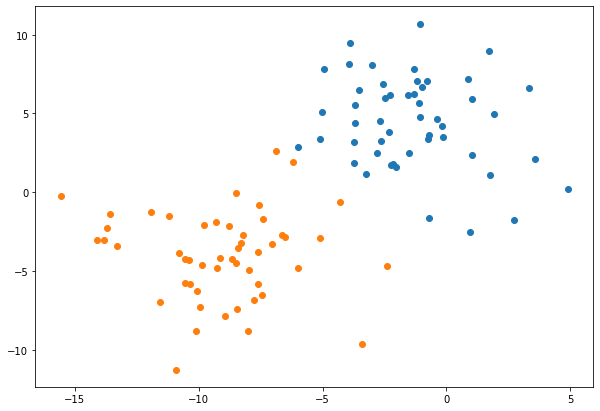

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
import numpy as np

x, yo = make_blobs(n_samples=100, centers=2, n_features=2, random_state=1, cluster_std=3)
rng = np.random.RandomState(2)

fig = plt.figure(figsize = (10, 7))
for class_value in range(2):
	# get row indexes for samples with this class
	row_ix = jnp.where(yo == class_value)
	# create scatter of these samples
	plt.scatter(x[row_ix, 0], x[row_ix, 1])
# show the plot
plt.show()

In [4]:
key1, key2 = random.split(random.PRNGKey(10), 2)

In [5]:
model = SimpleMLP(features=[2, 2,1])

params = model.init(key2, x)

print(jax.tree_util.tree_map(lambda x: x.shape, params))

FrozenDict({
    params: {
        layers_0: {
            bias: (2,),
            kernel: (2, 2),
        },
        layers_1: {
            bias: (2,),
            kernel: (2, 2),
        },
        layers_2: {
            bias: (1,),
            kernel: (2, 1),
        },
    },
})


In [6]:
#define the loss
def loss(params,xs,ys):
  logits = model.apply(params, xs)
  return jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=ys.reshape(-1, 1)))

In [7]:
#Shape of the output and ground truths
model.apply(params, x).shape
yo=yo.reshape(-1,1)
print(yo.shape)

(100, 1)


In [8]:
#Do gradient descent now
learning_rate = 0.1  # Gradient step size.

print('Loss for "true" W,b: ', loss(params,x,yo))
loss_grad_fn = jax.value_and_grad(loss)

@jax.jit
def update_params_loss(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params
loss_values=[]
for i in tqdm(range(200)):
  # Perform one gradient update.
  loss_val, grads = loss_grad_fn(params,x,yo)
 
  params = update_params_loss(params, learning_rate, grads)
  #print(params)
  loss_values.append(loss_val)
  

  if (i % 10 == 0):
    print(f'Loss step {i}: ', loss_val)

Loss for "true" W,b:  1.0363841


  1%|          | 2/200 [00:01<01:39,  1.99it/s]

Loss step 0:  1.0363841


  6%|▌         | 12/200 [00:02<00:20,  9.07it/s]

Loss step 10:  0.49856368


 11%|█         | 22/200 [00:03<00:20,  8.66it/s]

Loss step 20:  0.43438154


 16%|█▌        | 32/200 [00:04<00:18,  9.20it/s]

Loss step 30:  0.3876294


 21%|██        | 42/200 [00:05<00:17,  9.06it/s]

Loss step 40:  0.3490838


 26%|██▌       | 51/200 [00:07<00:26,  5.72it/s]

Loss step 50:  0.31774142


 31%|███       | 62/200 [00:09<00:28,  4.77it/s]

Loss step 60:  0.28355858


 36%|███▌      | 71/200 [00:12<00:41,  3.07it/s]

Loss step 70:  0.2568191


 41%|████      | 82/200 [00:14<00:26,  4.42it/s]

Loss step 80:  0.23828088


 46%|████▌     | 91/200 [00:17<00:25,  4.25it/s]

Loss step 90:  0.22513694


 50%|█████     | 101/200 [00:19<00:24,  3.96it/s]

Loss step 100:  0.21420753


 56%|█████▌    | 111/200 [00:21<00:21,  4.10it/s]

Loss step 110:  0.20500462


 60%|██████    | 121/200 [00:24<00:21,  3.65it/s]

Loss step 120:  0.19719066


 66%|██████▌   | 132/200 [00:27<00:14,  4.57it/s]

Loss step 130:  0.19050483


 70%|███████   | 141/200 [00:30<00:15,  3.81it/s]

Loss step 140:  0.1847429


 76%|███████▌  | 151/200 [00:32<00:11,  4.26it/s]

Loss step 150:  0.17971547


 81%|████████  | 162/200 [00:34<00:04,  8.87it/s]

Loss step 160:  0.17525744


 86%|████████▌ | 172/200 [00:35<00:03,  8.94it/s]

Loss step 170:  0.17143065


 91%|█████████ | 182/200 [00:36<00:02,  7.74it/s]

Loss step 180:  0.16805026


 96%|█████████▌| 192/200 [00:37<00:00,  9.06it/s]

Loss step 190:  0.1650486


100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


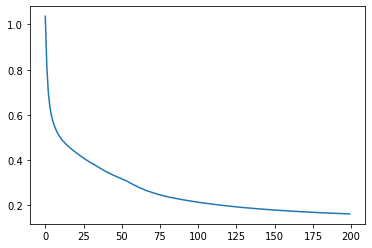

In [9]:
#print(loss_values)
plt.plot(loss_values)

In [10]:
#Now check the accuracy of this neural network
y_pred=model.apply(params, x)
y_pred=jax.nn.sigmoid(y_pred)

Pred=(y_pred>0.5).astype(int)

k=0
for i in range(100):
  if(Pred[i]==yo[i]):
    k+=1
print('Accuracy is :', (k))   



Accuracy is : 96


In [11]:
#Negative log likelihood calculation without prior. Bernoulli distribution is assumed since it's a binary classification job
import tensorflow_probability.substrates.jax as tfp
tfd=tfp.distributions

def log_likelihood_without_prior(params,x):
    
    Log_likelihood=0
    for i in range(len(x[:,0])):
        
        logits=model.apply(params,x)[i]                #this is the i-th example and a forward pass will give me the p to apply into the Bernoulli distribution
        bernoulli_dist=tfd.Bernoulli(logits=logits)
        Log_likelihood+=bernoulli_dist.log_prob(yo[i])
    
    return Log_likelihood

In [12]:
print(log_likelihood_without_prior(params,x))

[-16.237005]


In [13]:
#Now we come to adding the prior part. We assume a normal distribution for the parameters of the model
import jax.flatten_util as flatten_util 
def log_likelihood_with_prior(params,x):
    
    vec=flatten_util.ravel_pytree(params)[0]        #This will return a vector of parameters
   
    mu=[0.0]*(len(vec))
    cov=jnp.identity(len(vec))
    mvn=tfd.MultivariateNormalFullCovariance(       #Here we make a multivariate normal distribution of the same dimensions
    loc=mu,                                         #as the parameters.
    covariance_matrix=cov)
    
    
    #vec=ret_vector(params,layers)
    
    p2=mvn.log_prob(vec)                            #This will be the log P(theta)
    #prior_part=mvn.log_prob(ret_vector(params,layers))
    return -jnp.mean((p2+log_likelihood_without_prior(params,x)))   #This will be our final NLL that needs to be minimized for finding MAP parameters

In [14]:

log_likelihood_with_prior(params,x)   #we are actually getting a negative log likelihood with prior

#This mean that at least in this part, mvn.log_prob(vec) is working 

DeviceArray(36.107292, dtype=float32)

In [ ]:
loss_grad_fn_likelihood = jax.value_and_grad(log_likelihood_with_prior)
lr=0.1
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)  # always the same pattern - handling state externally



In [ ]:
#trying to minimize the NLL 
#Here, the mvn.log_prob(vec) is not working. Some kind of coversion error. 

params = model.init(key2, x)  # let's start with fresh params again
epochs=100
log_period_epoch=10
losss_val=[]
for epoch in range(epochs):
    loss, grads = loss_grad_fn_likelihood(params,x)
    updates, opt_state = opt_sgd.update(grads, opt_state)  # arbitrary optim logic!
    params = optax.apply_updates(params, updates)
    losss_val.append(loss)
    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

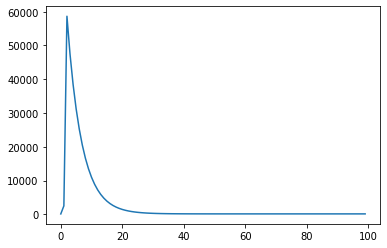

In [ ]:
plt.plot(losss_val)

In [ ]:
from jax import flatten_util

loss_grad_fn_likelihood = jax.value_and_grad(log_likelihood_with_prior)

learning_rate=0.01

@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

  
loss_values=[]
for i in tqdm(range(500)):
  # Perform one gradient update.
  loss_val, grads = loss_grad_fn_likelihood(params, x)
  params = update_params(params, learning_rate, grads)
  loss_values.append(loss_val)
  # if i % 10 == 0:
  #   print(f'Loss step {i}: ', loss_val)



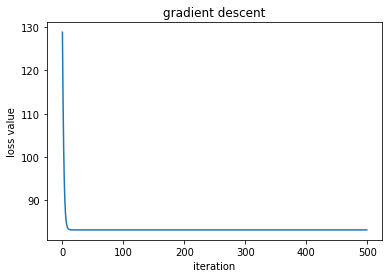

In [ ]:
plt.plot(loss_values)
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.title("gradient descent")
plt.show()

In [ ]:
#The MAP parameters has been learned
#Now we need to find the hessian matrix

In [15]:
theta_map=params     #still in pytrees form
t_map=flatten_util.ravel_pytree(params)[0] #This is a vector theta MAP



In [16]:
t_map.shape #this gives the correct number of parameters in a [2,2,2,1] neural net with the first indix being the number of input features

#Now we move on to calculating the hessian matrix

(15,)

In [17]:
hess=jax.hessian(log_likelihood_with_prior)(t_map,x)
sigma=np.linalg.inv(hess)

AttributeError: ignored

In [ ]:
tfd = tfp.distributions

# This gives us the laplace approximation distribution to be used in MC Sampling and calculation of posterior predictive

lap_appro= tfd.MultivariateNormalFullCovariance(
    loc=t_map,
    covariance_matrix=sigma)

In [ ]:
def MC_sampling(mvn): 
  MC_samples = mvn.sample(20, seed=jax.random.PRNGKey(1602))
  return MC_samples

In [ ]:
a=lap_appro

In [ ]:
k=MC_sampling(a)

In [ ]:
def posterior_predictive(samples, input_x, dims): #dims will be a list with dimensions of the neural network and it will hence determine the shape of the weights
  #here we must turn each sample into a set of params to be sent for forward pass through the network
  posterior_predictive=0
  dummy=unfreeze(params)
  for i in range(len(samples[:,0])):
    #print("test1")
    shape=dims
    #print(len(shape))
    pos=0
    for j in range(len(shape)-1):
      count=shape[j]*shape[j+1]  #This will be the shape of the W matrix (We are not tuning the b matrices)
      
      val=samples[i][pos:pos+count]
      #print(val)
      #print("test2")
      dummy["params"][f"layers_{j}"]["kernel"]=jnp.array(val).reshape(shape[j],shape[j+1])
      #print(dummy)
      pos+=count
    #print(dummy)
    new_params_i = freeze(dummy) # here we free the dictionary again
    print(new_params_i)
    sum=model.apply(new_params_i, input_x)                      #this is the likelihood that we get 
    #sum=jax.nn.sigmoid(sum)
    posterior_predictive+=sum
  return posterior_predictive/len(samples[:,0]) 


In [ ]:
#print(x[0,:].shape)
print(posterior_predictive(k,x[0,:],[len(x[0,:]),2,1])) #dims include input

In [ ]:
#This was the posterior predictive probability of y=1
#Now we check the accuracy of the model using posterior precictive
total_correct_pred=0
for j in range(1000):
  pred_post=posterior_predictive(k,x[j,:],[len(x[j,:]),2,1])
  pred_post=(pred_post>0.5).astype(int)
  if yo[j]==pred_post:
    total_correct_pred+=1
  else:
    total_correct_pred+=0

print("accuracy =", total_correct_pred)    